In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mnist import load_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
train, validation, test = load_mnist()
X_train, y_train = train
X_test, y_test = test

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


In [4]:
train[0].shape, train[1].shape

((55000, 28, 28, 1), (55000,))

In [5]:
train[1]

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

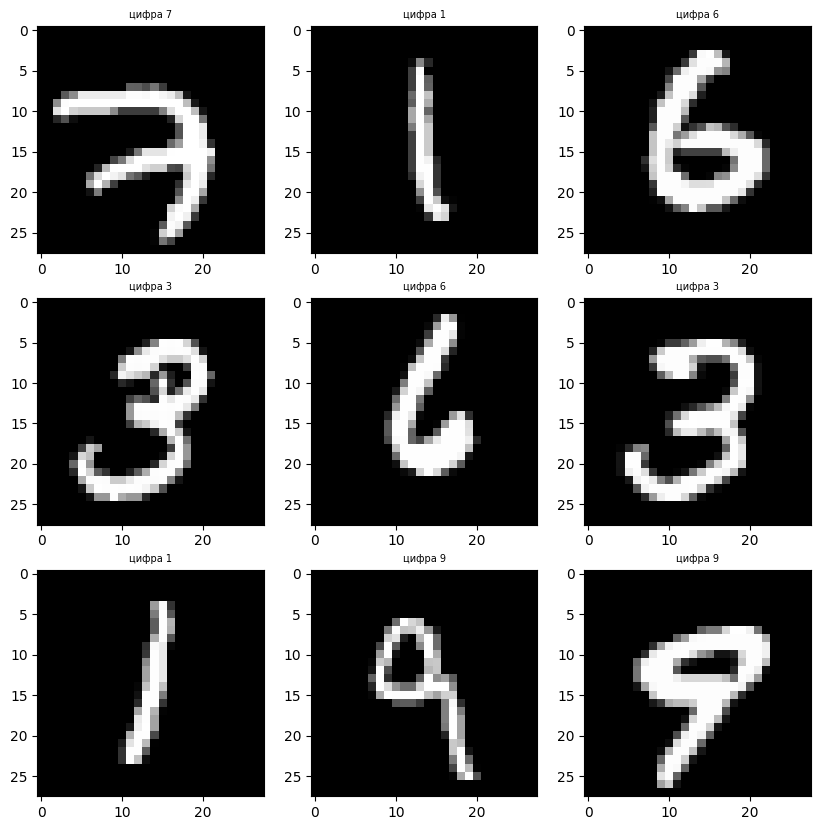

In [6]:
fig, axis = plt.subplots(3, 3, figsize = (10,10))
for i in range(3):
    for j in range(3):
        axis[i, j].imshow(train[0][i**2 + 20 * j], cmap = 'gray')
        axis[i, j].set_title('цифра ' + str(train[1][i**2 + 20 * j]), fontdict = {'fontsize':7})

In [8]:
class my_PCA():
    def __init__(self, n_components = None):
        self.n_components = n_components
        self.mean = None
        self.eigenvectors = None
        self.eigenvalues = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        centered_X = X - self.mean
        cov_matrix = np.cov(centered_X, rowvar = False)
        self.eigenvalues, self.eigenvectors = np.linalg.eig(cov_matrix)

        idx = np.argsort(self.eigenvalues)[::-1]
        self.eigenvalues = self.eigenvalues[idx]
        self.eigenvectors = self.eigenvectors[:, idx]

    def transform(self, X):
        centered_X = X - self.mean
        if self.n_components is not None:
            reduced_eigenvectors = self.eigenvectors[:, :self.n_components]
            return np.dot(centered_X, reduced_eigenvectors)
        else:
            return np.dot(centered_X, self.eigenvectors)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

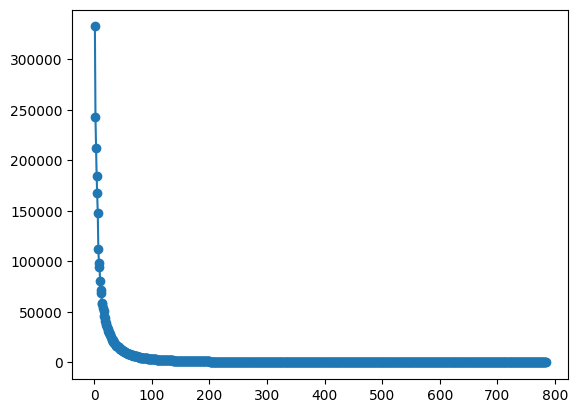

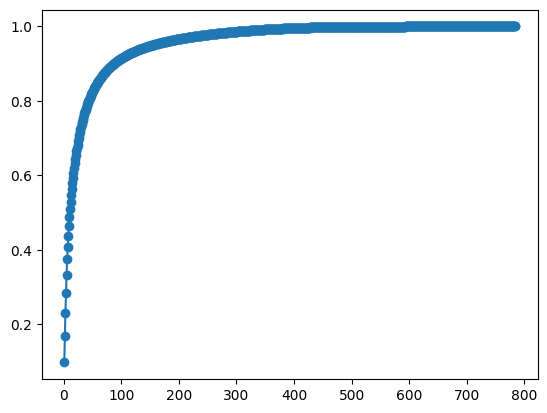

In [9]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

pca = my_PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

plt.plot(np.arange(1, 785), pca.eigenvalues, marker = 'o', linestyle = '-')
plt.show()

cumulative_sum = np.cumsum(pca.eigenvalues) / np.sum(pca.eigenvalues)
plt.plot(np.arange(1, 785), cumulative_sum, marker = 'o', linestyle = '-')
plt.show()

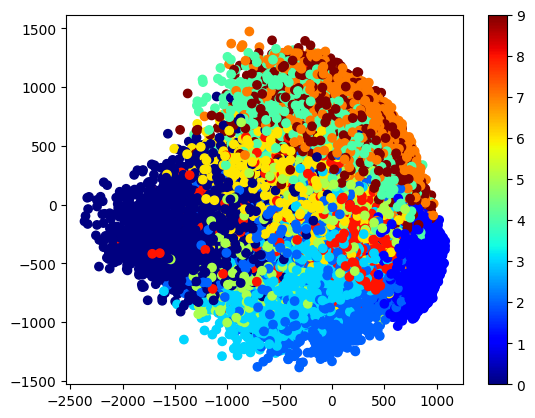

In [10]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c = y_train, cmap = 'jet')
plt.colorbar()
plt.show()

In [11]:
class my_kNN():
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        distances = np.sqrt(np.sum((X[:, np.newaxis] - self.X_train)**2, axis = 2))
        nearest_indices = np.argsort(distances, axis=1)[:, :self.n_neighbors]
        nearest_labels = self.y_train[nearest_indices]
        predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis = 1, arr = nearest_labels)
        return predictions

In [81]:
X_train, X_val, y_train, y_val = train_test_split(X_train_pca, y_train, test_size = 0.2, random_state = 42)

knn = my_kNN(n_neighbors = 5)
knn.fit(X_train_pca, y_train)

y_pred = knn.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.41145454545454546


In [ ]:
best_accuracy = 0
best_params = {}

for n_components in range(1, 65):
    for n_neighbors in range(1, 31):
        pca = my_PCA(n_components = n_components)
        X_train_pca = pca.fit_transform(X_train)

        knn = my_kNN(n_neighbors=n_neighbors)
        knn.fit(X_train_pca, y_train)
        X_val_pca = pca.transform(X_val)
        y_pred = knn.predict(X_val_pca)

        accuracy = accuracy_score(y_val, y_pred)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params['n_components'] = n_components
            best_params['n_neighbors'] = n_neighbors

print("Наилучшая точность:", best_accuracy)
print("Наилучшие параметры:", best_params)